### Project Notes

* Airlines are in trouble and customers are "up for grabs". My audience is a group of C-leaders at an airline looking to understand how to retain current customers and capture new customers. I'll ultimately create a business case to justify my finding around the cost of losing a customer. 

-XG Boost

Post model: Determine which features are most important
-business case, interpretability may not be necessary

EDA Options

    * check distributions of travel type, gender, class
    * do I want to bin age group data?
    * log transformations for highly skewed data?

* Bias in dataset? more likely to take survey if satisfied/dissatisfied?

    * Do I have an imbalanced data set? ---SLIGHTLY
        * Accuracy versus recall/precision

* Precision or recall?
    * care more about getting dissatisfied customers correct?
    * more expensive to lose a customers
    * customer churn/dissatisfaction
    * how much to lose a customer? 
    * lifetime value of an airline customer
    * Create a business case for losing customer/risk
    * What is the cost of getting dissatisfied customer wrong?

    * GOAL: collect highest number of actually dissastisfied
        * dissatisfied is the positive (1, more important class)
        * precision: capturing dissatisfied, maximize actually dissatisfied (more scrutinous)
        * recall: make call happy passengers, grab as many dissatisfieds, even if some aren't dissatisfied              * (don't care about false positive)
        
**Model Optimization**
- What are most important features
- confusion matrix/results for KNN
- ROC curve
- Area under the ROC curve
- Post model analysis: segment population into age ranges and which ages do they perform

Will eventually use ROC curve to compare algorithms (make decisions one level removed from model through graph).

- Flask app video at end of presentation?

In [625]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from scipy.spatial.distance import euclidean as euc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [626]:
#import table from Postgres as dataframe

connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'airline_passenger_data',    # DB that we are connecting to
    'port': 5432          # port we opened on AWS
}

connection = pg.connect(**connection_args) 

query = "SELECT * FROM survey_data1;"

df = pd.read_sql(query, connection)

In [627]:
#clean column names
df.columns=df.columns.str.strip().str.title().str.replace('_', ' ')

#drop first column
df = df.drop(columns = ['Col'])

# check for null values and drop 'Arrival Delay in Minutes' null values
df.isnull().sum()
df = df.dropna(subset = ['Arrival Delay In Minutes']) 

# change dtypes from object to int
df["Age"] = df["Age"].astype(str).astype(int)
df["Flight Distance"] = df["Flight Distance"].astype(str).astype(int)
df["Inflight Wifi Service"] = df["Inflight Wifi Service"].astype(str).astype(int)
df["Dep Arr Time Convenience"] = df["Dep Arr Time Convenience"].astype(str).astype(int)
df["Ease Of Online Booking"] = df["Ease Of Online Booking"].astype(str).astype(int)
df["Gate Location"] = df["Gate Location"].astype(str).astype(int)
df["Food And Drink"] = df["Food And Drink"].astype(str).astype(int)
df["Online Boarding"] = df["Online Boarding"].astype(str).astype(int)
df["Leg Room Service"] = df["Leg Room Service"].astype(str).astype(int)
df["Checkin Service"] = df["Checkin Service"].astype(str).astype(int)
df["Inflight Service"] = df["Inflight Service"].astype(str).astype(int)
df["Cleanliness"] = df["Cleanliness"].astype(str).astype(int)
df["Departure Delay In Minutes"] = df["Departure Delay In Minutes"].astype(str).astype(int)

# clean target value string
df.loc[(df['Customer Type'] == 'Loyal Customer'),'Customer Type']= str('Loyal')
df.loc[(df['Customer Type'] == 'disloyal Customer'),'Customer Type']= str('Disloyal')

In [628]:
df.head(3)

,Id,Gender,Customer Type,Age,Type Of Travel,Class,Flight Distance,Inflight Wifi Service,Dep Arr Time Convenience,Ease Of Online Booking,...,Inflight Entertainment,Onboard Service,Leg Room Service,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Departure Delay In Minutes,Arrival Delay In Minutes,Satisfaction
0,19556,Female,Loyal,52,Business travel,Eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal,36,Business travel,Business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,Disloyal,20,Business travel,Eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied


In [629]:
#129,487 customer record rows
#24 total columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129487 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Id                          129487 non-null  object
 1   Gender                      129487 non-null  object
 2   Customer Type               129487 non-null  object
 3   Age                         129487 non-null  int64 
 4   Type Of Travel              129487 non-null  object
 5   Class                       129487 non-null  object
 6   Flight Distance             129487 non-null  int64 
 7   Inflight Wifi Service       129487 non-null  int64 
 8   Dep Arr Time Convenience    129487 non-null  int64 
 9   Ease Of Online Booking      129487 non-null  int64 
 10  Gate Location               129487 non-null  int64 
 11  Food And Drink              129487 non-null  int64 
 12  Online Boarding             129487 non-null  int64 
 13  Seat Comfort                1

## Exploratory Data Analysis

### Should I remove outliers for Departure Delay in Minutes?

- could log transformation
- slight vs. average vs. extreme delay 
- customers remember extreme situations!
- what is the cost of not predicting dissatisfied customer

In [630]:
delay_std = round(np.std(df['Departure Delay In Minutes']), 2)
delay_mean = round(df['Departure Delay In Minutes'].mean(), 2)
print('STD departure delay (minutes):', + delay_std)
print('Mean departure delay (minutes):', + delay_mean)

STD departure delay (minutes): 37.93
Mean departure delay (minutes): 14.64


In [631]:
import numpy as np
import matplotlib.pyplot as plt
# seed(1)

# multiply and add by random numbers to get some real values
data = df['Departure Delay In Minutes']

#define list to accumulate anomalies
anomalies = []
# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(data):
    
    
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(data)
    random_data_mean = np.mean(data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    print(lower_limit, ": lower limit")
    print(upper_limit, ": upper limit")
    # Generate outliers
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    print(len(anomalies), 'is the number of outliers.')
    return anomalies

find_anomalies(data)

-99.1547751767204 : lower limit
128.44154527719382 : upper limit
2716 is the number of outliers.


[180,
 168,
 243,
 152,
 238,
 150,
 141,
 132,
 132,
 140,
 214,
 145,
 277,
 129,
 493,
 332,
 136,
 416,
 137,
 187,
 247,
 145,
 129,
 146,
 130,
 222,
 163,
 205,
 275,
 167,
 142,
 204,
 170,
 258,
 132,
 155,
 202,
 951,
 190,
 202,
 214,
 266,
 290,
 209,
 315,
 302,
 136,
 154,
 143,
 144,
 135,
 228,
 146,
 137,
 214,
 203,
 138,
 366,
 149,
 135,
 134,
 211,
 190,
 184,
 137,
 131,
 132,
 185,
 130,
 154,
 132,
 352,
 156,
 157,
 140,
 142,
 151,
 188,
 131,
 130,
 132,
 145,
 166,
 196,
 151,
 161,
 144,
 168,
 141,
 197,
 255,
 157,
 199,
 166,
 157,
 136,
 381,
 130,
 156,
 151,
 146,
 163,
 139,
 153,
 163,
 146,
 225,
 223,
 161,
 284,
 251,
 293,
 149,
 298,
 213,
 184,
 312,
 177,
 396,
 148,
 217,
 202,
 132,
 187,
 243,
 145,
 162,
 162,
 197,
 222,
 161,
 384,
 167,
 294,
 148,
 170,
 244,
 130,
 178,
 167,
 131,
 182,
 151,
 224,
 162,
 148,
 244,
 149,
 489,
 158,
 137,
 207,
 202,
 404,
 138,
 165,
 232,
 197,
 189,
 178,
 265,
 175,
 134,
 138,
 179,
 447,
 234

### Should I remove passengers under 12?

In [632]:
#df = df[df['Age'] >= 12]

In [633]:
# Balance of dataset

# imbalance = a random oversampler (of minority class)
# could undersample
# over representation of minority class

balance = df['Satisfaction'].value_counts('neutral or dissatisfied')
balance

neutral or dissatisfied    0.565501
satisfied                  0.434499
Name: Satisfaction, dtype: float64

### Correlations

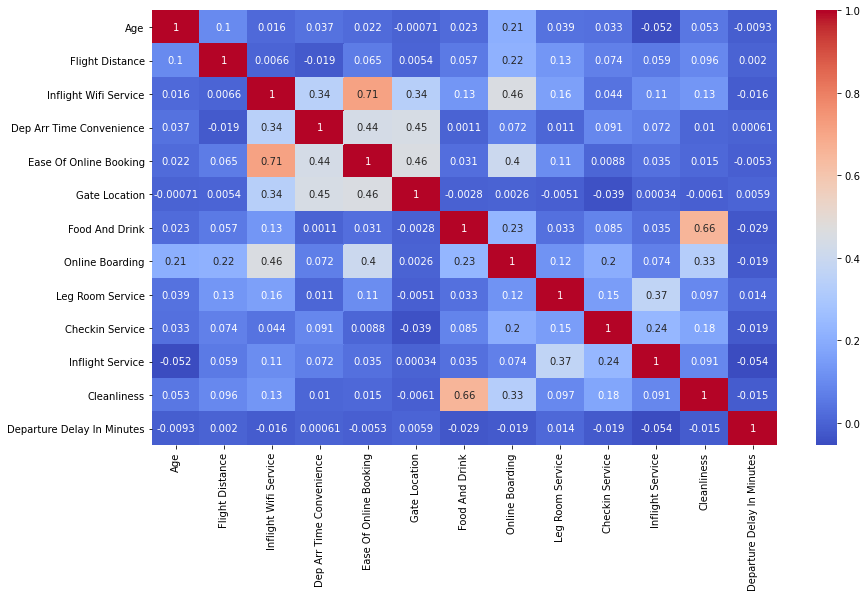

In [634]:
# drop arrival delay in minutes
# some may be highly correlated (high score) but not worth dropping yet until see how model performs

plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), cmap= 'coolwarm', annot=True);

In [635]:
# drop as arrival and departure delay are co-linear

df = df.drop(['Arrival Delay In Minutes'], axis =1 )


In [636]:
# Passenger Age Distribution
# post model analysis: segment population into age ranges and which ages do they perform
# 5-10k teenagers are included in sample (not paying customers/ highly influenced by parnets)

Assume data is correct unless proven otherwise.

sns.distplot(df['Age'], hist=True, kde=False, 
             bins=int(100/5), color = 'green',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Passenger Age')
plt.xlabel('Years')
plt.ylabel('Customers')

SyntaxError: invalid syntax (<ipython-input-636-172aa26607ee>, line 5)

In [ ]:
sns.distplot(df['Age']);

In [ ]:
df['Gender'].value_counts()

Text(0.5, 1.0, 'Side-by-Side Histogram with Genders')

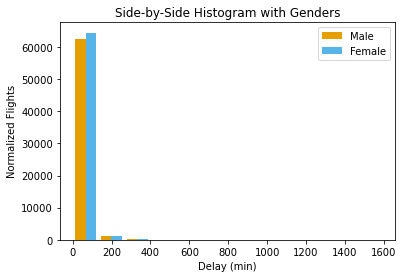

In [639]:
# Make a separate list for each gender
x1 = list(df[df['Gender'] == 'Male']['Departure Delay In Minutes'])
x2 = list(df[df['Gender'] == 'Female']['Departure Delay In Minutes'])

# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9']
names = ['Male', 'Female']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2], bins = int(180/15), #normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Delay (min)')
plt.ylabel('Normalized Flights')
plt.title('Side-by-Side Histogram with Genders')

Text(0.5, 1.0, 'Side-by-Side Histogram with Class Types')

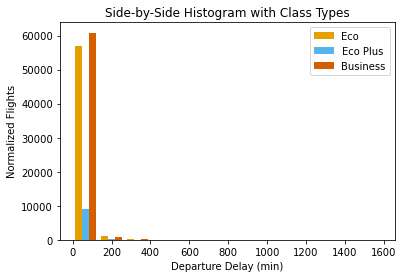

In [640]:
#Eco, Eco Plus, Business Class Hisotgram by Departure Delay in Minutes

# Make a separate list for each Class
x1 = list(df[df['Class'] == 'Eco']['Departure Delay In Minutes'])
x2 = list(df[df['Class'] == 'Eco Plus']['Departure Delay In Minutes'])
x3 = list(df[df['Class'] == 'Business']['Departure Delay In Minutes'])


# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9', '#D55E00']
names = ['Eco', 'Eco Plus', 'Business']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2, x3], bins = int(180/15), #normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Departure Delay (min)')
plt.ylabel('Normalized Flights')
plt.title('Side-by-Side Histogram with Class Types')

In [641]:
df['Class'].value_counts()

Business    61990
Eco         58117
Eco Plus     9380
Name: Class, dtype: int64

Text(0.5, 1.0, 'Side-by-Side Histogram with Genders')

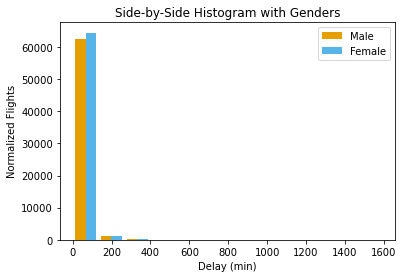

In [642]:
# Make a separate list for each gender
x1 = list(df[df['Gender'] == 'Male']['Departure Delay In Minutes'])
x2 = list(df[df['Gender'] == 'Female']['Departure Delay In Minutes'])


# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9']
names = ['Male', 'Female']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2], bins = int(180/15), #normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Delay (min)')
plt.ylabel('Normalized Flights')
plt.title('Side-by-Side Histogram with Genders')

Text(0, 0.5, 'Flights')

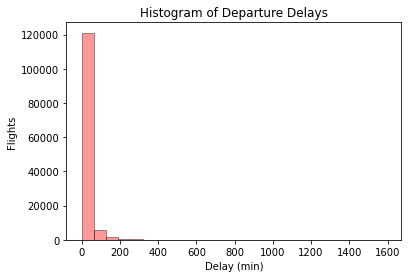

In [643]:
# Departure Delay Distribution
sns.distplot(df['Departure Delay In Minutes'], hist=True, kde=False, 
             bins=int(250/10), color = 'red',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Departure Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Flights')

In [644]:
df['Customer Type'].value_counts()

Loyal       105773
Disloyal     23714
Name: Customer Type, dtype: int64

Loyal       105773
Disloyal     23714
Name: Customer Type, dtype: int64

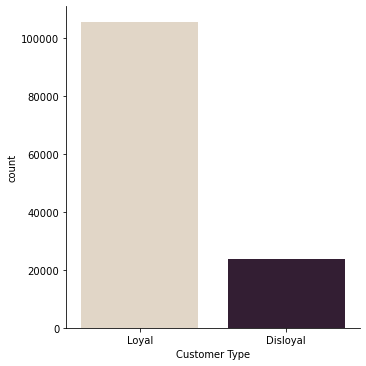

In [645]:
sns.catplot(x="Customer Type", kind="count", palette="ch:.25", data=df);
df["Customer Type"].value_counts()

In [648]:
df.to_csv('df_clean.csv')